## **This notebook generates segmentation results for the validation dataset with input size of 128 X 128 and stores them in the google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install nilearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation ,Dropout
from keras.layers.convolutional import Conv2D, UpSampling2D,Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
import pickle
import skimage.transform as skTrans
from nilearn import image
from nilearn.image import resample_img
import nibabel.processing
import warnings
import shutil

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/MRI Data/BraTS2020_ValidationData'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
"""
rescale_Nii(nifti_file):
This function takes a .nii files as an input and rescales it according to the 
values of voxel_dims by creating a new affine transform. The new affine transform
is used in resample_img() function from nibable library which will transform the images
accordinly inputs for resample_img() are tagert image, target affine transform and target shape

Input:
nifti_file: A .nii file which we want to rescale

Output:
rescaled .nii file with dimensions as defined in target_shape
"""
def rescale_Nii(nifti_file):
    warnings.filterwarnings("ignore")
    img=nifti_file
    #voxel_dims=[3.8, 3.8,1]
    voxel_dims=[1.60, 1.60,1]
    

    # downl sample to 128*128*155
    #target_shape=(64,64,130)
    target_shape=(128,128,155)
    # Initialize target_affine
    target_affine = img.affine.copy()
    # Calculate the translation part of the affine
    spatial_dimensions = (img.header['dim'] * img.header['pixdim'])[1:4]
    
    # Calculate the translation affine as a proportion of the real world
    # spatial dimensions
    image_center_as_prop = img.affine[0:3,3] / spatial_dimensions
    
    # Calculate the equivalent center coordinates in the target image
    dimensions_of_target_image = (np.array(voxel_dims) * np.array(target_shape))
    target_center_coords =  dimensions_of_target_image * image_center_as_prop
    # Decompose the image affine to allow scaling
    u,s,v = np.linalg.svd(target_affine[:3,:3],full_matrices=False)
    
    # Rescale the image to the appropriate voxel dimensions
    s = voxel_dims
    
    # Reconstruct the affine
    target_affine[:3,:3] = u @ np.diag(s) @ v

    # Set the translation component of the affine computed from the input
    target_affine[:3,3] = target_center_coords 
  

    #target_affine = rescale_affine(target_affine,voxel_dims,target_center_coords)
    resampled_img = resample_img(img, target_affine=target_affine,target_shape=target_shape)
    resampled_img.header.set_zooms((np.absolute(voxel_dims)))
    return resampled_img
   

In [ ]:
"""
Data_Preprocessing(modalities_dir):

This function takes the images from each modality and outputs a fused image based on their average

Input:
modalities_dir: List of all the modalities present in the dataset.

Output:
P_Data: nummpy array with fused images made from all the modalities

"""
def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:   
        nifti_file   = nib.load(modality)
        #nifti_file= rescale_Nii(nifti_file)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    avg_modality=[]
    for i in range(len(all_modalities)):
      x=(all_modalities[i,:,:,0]+all_modalities[i,:,:,1]+all_modalities[i,:,:,2]+all_modalities[i,:,:,3])/4
      avg_modality.append(x)  
    gt=all_modalities[:,:,:,4]
    P_Data=np.stack(np.stack((avg_modality, gt), axis = -1))
    #P_Data=np.stack(np.stack((avg_modality), axis = -1))#for validation dataset 
    
    

    return P_Data

In [ ]:
"""
Data_Concatenate(Input_Data):
Converts a numpy array with fused images ( eg: (20, 130, 128, 128, 2)) 
into an array with two partitions(eg: (2, 2600, 128, 128, 1)).

Input:
Input_Data= Array which contains information of all the modalities

Output:
Fused array which will used for making the training and testing split

"""
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(2):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):

            if (counter < len(Input_Data)-1):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if (counter==0):
                    c= np.concatenate((a, b), axis=0)
                    #print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
            
            if (counter == len(Input_Data)-1):
              a= Input_Data[counter][:,:,:,i]
              c= np.concatenate((c, a), axis=0)
              print('c2={}'.format(c.shape))
              counter=counter+2

        print('c2={}'.format(c.shape))
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

In [ ]:
"""
#add dummy .seg file 
Path='/content/drive/MyDrive/MRI Data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'# for validation dataset 
p=os.listdir(Path)
Input_Data= []
t='/content/drive/MyDrive/MRI Data/BraTS2020_ValidationData/BraTS20_Validation_001_seg.nii'

for i in p[3:125]:
    
    target = os.path.normpath(Path+'/'+i)
    shutil.copy(t,target)
""" 

### **Data Preprocessing**

In [ ]:
Path='/content/drive/MyDrive/MRI Data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'# for validation dataset 
p=os.listdir(Path)
Input_Data= []

#perform preprocessing for whole validation set
for i in p[:125]:
  
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)
    print('This is done ', i)


This is done  BraTS20_Validation_001
This is done  BraTS20_Validation_002
This is done  BraTS20_Validation_003
This is done  BraTS20_Validation_004
This is done  BraTS20_Validation_005
This is done  BraTS20_Validation_006
This is done  BraTS20_Validation_007
This is done  BraTS20_Validation_008
This is done  BraTS20_Validation_009
This is done  BraTS20_Validation_010
This is done  BraTS20_Validation_011
This is done  BraTS20_Validation_012
This is done  BraTS20_Validation_013
This is done  BraTS20_Validation_014
This is done  BraTS20_Validation_016
This is done  BraTS20_Validation_015
This is done  BraTS20_Validation_017
This is done  BraTS20_Validation_018
This is done  BraTS20_Validation_019
This is done  BraTS20_Validation_020
This is done  BraTS20_Validation_021
This is done  BraTS20_Validation_022
This is done  BraTS20_Validation_023
This is done  BraTS20_Validation_024
This is done  BraTS20_Validation_025
This is done  BraTS20_Validation_026
This is done  BraTS20_Validation_027
T

In [ ]:
print("Input_Data Shape:",np.shape(Input_Data))
print("Input_Data length:",len(Input_Data))

Input_Data Shape: (125, 155, 128, 128, 2)
Input_Data length: 125


In [ ]:
 # save the preprocessed data for future use
 with open('/content/drive/MyDrive/MRI Data/Partitioned/1-125_Validation'+'.pkl','wb') as f:
    pickle.dump(Input_Data,f)

In [ ]:
 #unpickle data
 with open('/content/drive/MyDrive/MRI Data/Partitioned/1-125_Validation'+'.pkl','rb') as f:
    Input_Data=pickle.load(f)

In [ ]:
InData= Data_Concatenate(Input_Data)

$
c2=(620, 128, 128)
c2=(930, 128, 128)
c2=(1240, 128, 128)
c2=(1550, 128, 128)
c2=(1860, 128, 128)
c2=(2170, 128, 128)
c2=(2480, 128, 128)
c2=(2790, 128, 128)
c2=(3100, 128, 128)
c2=(3410, 128, 128)
c2=(3720, 128, 128)
c2=(4030, 128, 128)
c2=(4340, 128, 128)
c2=(4650, 128, 128)
c2=(4960, 128, 128)
c2=(5270, 128, 128)
c2=(5580, 128, 128)
c2=(5890, 128, 128)
c2=(6200, 128, 128)
c2=(6510, 128, 128)
c2=(6820, 128, 128)
c2=(7130, 128, 128)
c2=(7440, 128, 128)
c2=(7750, 128, 128)
c2=(8060, 128, 128)
c2=(8370, 128, 128)
c2=(8680, 128, 128)
c2=(8990, 128, 128)
c2=(9300, 128, 128)
c2=(9610, 128, 128)
c2=(9920, 128, 128)
c2=(10230, 128, 128)
c2=(10540, 128, 128)
c2=(10850, 128, 128)
c2=(11160, 128, 128)
c2=(11470, 128, 128)
c2=(11780, 128, 128)
c2=(12090, 128, 128)
c2=(12400, 128, 128)
c2=(12710, 128, 128)
c2=(13020, 128, 128)
c2=(13330, 128, 128)
c2=(13640, 128, 128)
c2=(13950, 128, 128)
c2=(14260, 128, 128)
c2=(14570, 128, 128)
c2=(14880, 128, 128)
c2=(15190, 128, 128)
c2=(15500, 128, 128)
c2

In [ ]:
np.shape(InData)

(2, 19375, 128, 128, 1)

### **Predicting Tumor**

In [ ]:
def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))
    
    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model
# Loding the Light weighted CNN
model = model(input_shape = (128,128,1))

In [ ]:
AIO= concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,0],dtype='float32')
TRL=np.array(AIO[:,:,:,1],dtype='float32')#segmentation
AIO=TRL=0
AIO=np.array(AIO,dtype='float32')
model.load_weights('/content/drive/MyDrive/MRI Data/Model_History/BraTs2020_(Fused_0-369).h5')

In [ ]:
# Generate Segmentation Results
Segmentation = model.predict(TR)

In [ ]:
 # save Segmentation results for future use 
 with open('/content/drive/MyDrive/MRI Data/Partitioned/Segmentation_Results'+'.pkl','wb') as f:
    pickle.dump(Segmentation,f)

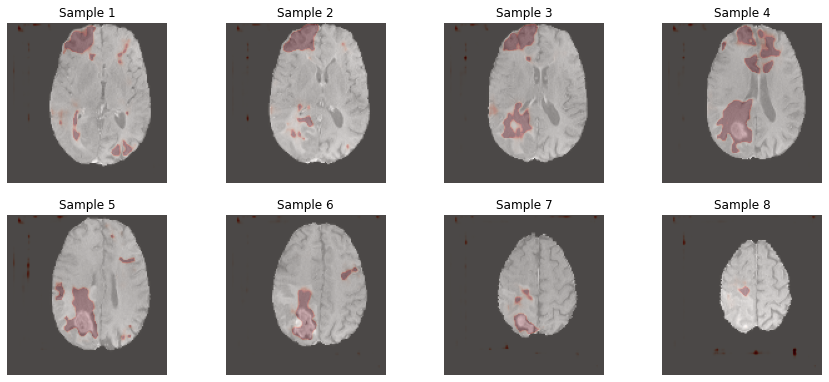

In [ ]:

x=0
plt.figure(figsize=(15,10))


plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(TR[x+70,:,:]),cmap='gray')
plt.imshow(np.squeeze(Segmentation[x+70,:,:,0]),alpha=0.3,cmap='Reds')


plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(TR[x+75,:,:]),cmap='gray')
plt.imshow(np.squeeze(Segmentation[x+75,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(TR[x+80,:,:]),cmap='gray')
plt.imshow(np.squeeze(Segmentation[x+80,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(TR[x+85,:,:]),cmap='gray')
plt.imshow(np.squeeze(Segmentation[x+85,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(TR[x+90,:,:]),cmap='gray')
plt.imshow(np.squeeze(Segmentation[x+95,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(TR[x+100,:,:]),cmap='gray')
plt.imshow(np.squeeze(Segmentation[x+105,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(TR[x+115,:,:]),cmap='gray')
plt.imshow(np.squeeze(Segmentation[x+115,:,:,0]),alpha=0.3,cmap='Reds')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(TR[x+120,:,:]),cmap='gray')
plt.imshow(np.squeeze(Segmentation[x+120,:,:,0]),alpha=0.3,cmap='Reds')

### **Saving Generated Results**

In [ ]:
# Unpickle Segmentation Results
with open('/content/drive/MyDrive/MRI Data/Partitioned/Segmentation_Results'+'.pkl','rb') as f:
    Segmentation=pickle.load(f)

In [ ]:
#converting Segmentation result back to 125 sections
Section=[]
previous=0
for i in range(len(Segmentation)):
  if (i % 155 == 0):
    a=Segmentation[i:i+155,:,:,0]
    Section.append(a)  

In [ ]:
Section = np.transpose(Section, (0,3,2,1))

In [ ]:
x=nib.load('/content/drive/MyDrive/MRI Data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001/BraTS20_Validation_001_flair.nii')
y=rescale_Nii(x)
target_affine=y.affine

In [ ]:
# Convert the numpy array to .nii.gz files 
counter=1
for i in range(len(Section)):
 
  data=Section[i]
  img = nib.Nifti1Image(data, target_affine)
  nib.save(img, '/content/drive/MyDrive/MRI Data/Final Segmentation Result/BraTS20_Validation_'+str(counter).zfill(3)+'.nii.gz')  
  print('/content/drive/MyDrive/MRI Data/Final Segmentation Result/BraTS20_Validation_'+str(counter).zfill(3)+'.nii.gz')
  counter=counter+1

In [ ]:
!zip -r /content/drive/MyDrive/MRI\ Data/MICCAI_BraTS2020_ValidationData.zip /content/drive/MyDrive/MRI\ Data/Final\ Segmentation\ Result